In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

movies_df = pd.read_csv(r'C:\Users\Administrator\Desktop\Studies\Python\Python_Project_Movie_Analysis\Python_Project_Movie_Analysis\0_Dataset\movies_metadata.csv', low_memory= False)

movies_df['release_date'] = pd.to_datetime(movies_df['release_date'],errors='coerce') # Convert data type of release_date to datetime.
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce') # Convert data type of budget to numeric.
movies_df['imdb_id'] = pd.to_numeric(movies_df['imdb_id'], errors='coerce') # Convert data type of imdb_id to numeric.
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce') # Convert data type of id to numeric.

def list_name(string_list_dict): # Convert the string list of dictionary into list of name.
    list_dict = ast.literal_eval(string_list_dict) if pd.notna(string_list_dict) else string_list_dict
    return [dict['name'] for dict in list_dict] if isinstance(list_dict,list) else []

movies_df['genres'] = movies_df['genres'].apply(lambda x: list_name(x))
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x: list_name(x))
movies_df['production_countries'] = movies_df['production_countries'].apply(lambda x: list_name(x))
movies_df = movies_df.dropna(subset= 'title', axis= 'index')

movies_df['release_month_no'] = movies_df['release_date'].dt.month
movies_df['release_month'] = movies_df['release_date'].dt.strftime('%b')

# What are the most common characteristics of successful movies?

A success movies can be define based on:
1. High Audience Rating (`vote_average` ≥ 8.0 and `vote_count` ≥ 1000)
2. High Profitability (`profit` in Top 10%)
3. Both rating + profit combined

I will going to check the characteristics listed below:

1. Genres
2. Runtime
3. Language
4. Budget
5. Release Year
6. Production Companies

### Successfull Movies

In [74]:
movies = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)].copy()
movies['profit'] = movies['revenue'] - movies['budget']
profit_threshold = movies['profit'].quantile(0.90)

successful_movies = movies[(movies['profit'] > profit_threshold) & (movies['vote_average'] >= 8.0) & (movies['vote_count'] >= 1000)]


### Genres

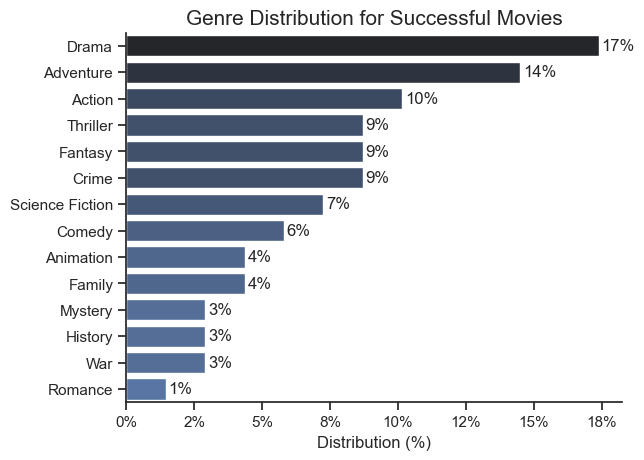

In [75]:
genres_explode = successful_movies.explode('genres')
genres_count = genres_explode['genres'].value_counts(normalize= True).reset_index(name= 'perc')

sns.set_theme(style= 'ticks')
sns.barplot(
    data= genres_count
    ,x= 'perc'
    ,y= 'genres'
    ,hue= 'perc'
    ,palette= 'dark:b_r'
    ,legend= False
    )
ax= plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,i: f'{x*100:.0f}%'))
for i,value in enumerate(genres_count['perc']):
    ax.text(
        x= value+0.001
        ,y= i
        ,s= f'{value*100:.0f}%'
        ,va= 'center'
    )
ax.spines[['top','right']].set_visible(False)
ax.set_title('Genre Distribution for Successful Movies', fontsize= 15)
ax.set_xlabel('Distribution (%)')
ax.set_ylabel('')
plt.show()


### Runtime

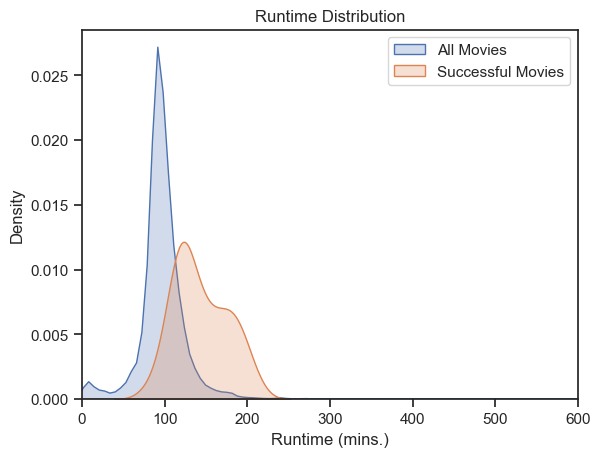

In [76]:
movies_runtime = movies_df[movies_df['runtime'] > 0 ]

sns.kdeplot(movies_runtime['runtime'], label='All Movies', fill=True)
sns.kdeplot(successful_movies['runtime'], label='Successful Movies', fill=True)
plt.title('Runtime Distribution')
plt.xlabel('Runtime (mins.)')
plt.xlim(0,600)
plt.legend()
plt.show()

### Language

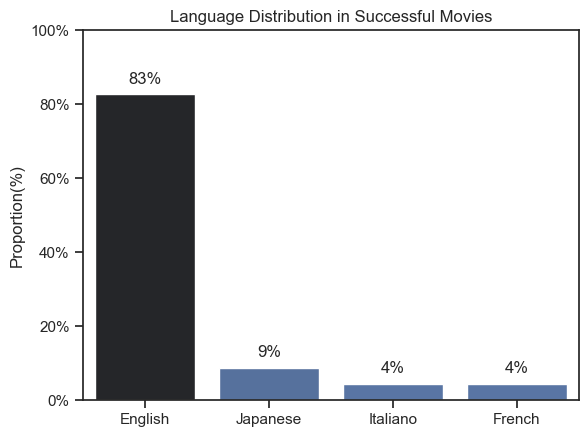

In [77]:
successfull_languages = successful_movies['original_language'].value_counts(normalize= True).reset_index(name= 'proportion')
successfull_languages['proportion'] = successfull_languages['proportion'] * 100

language = {'en':'English', 'ja':'Japanese', 'it':'Italiano', 'fr':'French'}
successfull_languages['original_language'] = successfull_languages['original_language'].map(language)

sns.set_theme(style= 'ticks')                     
sns.barplot(
    data= successfull_languages
    ,x= 'original_language'
    ,y='proportion'
    ,hue= 'proportion'
    ,palette= 'dark:b_r'
    ,legend= False
)
ax= plt.gca()

ax.set_xlabel('')
ax.set_ylabel('Proportion(%)')
ax.set_title('Language Distribution in Successful Movies')
ax.set_ylim(0,100)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,i : f'{x:.0f}%'))
for i,value in enumerate(successfull_languages['proportion']):
    ax.text(
        x= i
        ,y= value + 3
        ,s= f'{value:.0f}%'
        ,ha= 'center'
    )
plt.show()

### Budget

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1608\440433085.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_movies['budget_group'] = successful_movies['budget'].apply(budget_bucket)


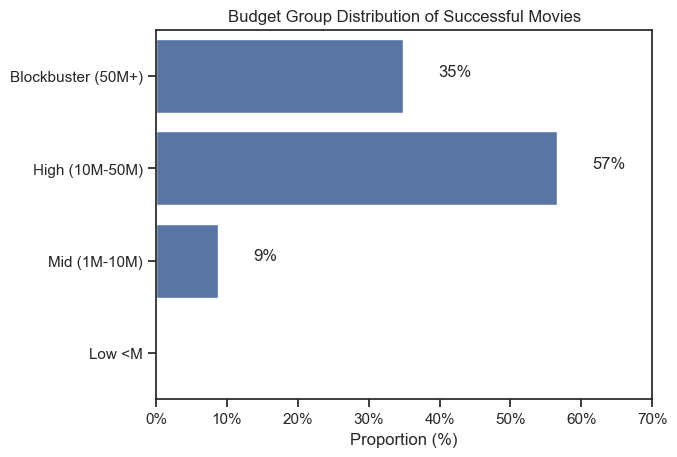

In [78]:
def budget_bucket(x):
    if x < 1e6:
        return 'Low <M'
    elif x < 1e7:
        return 'Mid (1M-10M)'
    elif x < 5e7:
        return 'High (10M-50M)'
    else:
        return 'Blockbuster (50M+)'

bucket = pd.DataFrame({'budget_group':['Low <M','Mid (1M-10M)','High (10M-50M)','Blockbuster (50M+)']})   
successful_movies['budget_group'] = successful_movies['budget'].apply(budget_bucket)
successful_budget_group = successful_movies['budget_group'].value_counts(normalize= True).reset_index(name='proportion')
budget_group_count = bucket.merge(right=successful_budget_group, how= 'left', on= 'budget_group')

sns.set_theme(style= 'ticks')
sns.barplot(
    data= budget_group_count
    ,x= 'proportion'
    ,y= 'budget_group'
)
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlabel('Proportion (%)')
ax.set_ylabel('')
ax.set_title('Budget Group Distribution of Successful Movies')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,i: f'{x*100:.0f}%'))
ax.set_xlim(0,0.70)
for i,value in enumerate(budget_group_count['proportion']):
    ax.text(
        x= value + 0.05
        ,y= i
        ,s= f'{value*100:.0f}%'
    )
plt.show()

## Release Date

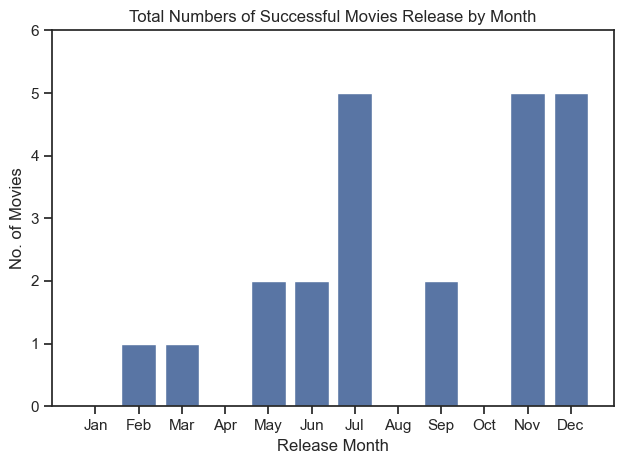

In [79]:
month_bucket = movies_df[['release_month','release_month_no']].drop_duplicates().dropna().sort_values('release_month_no')

successful_month_count = successful_movies['release_month_no'].value_counts().reset_index()
succesful_movies_month = month_bucket.merge(successful_month_count, how= 'left', left_on= 'release_month_no', right_on= 'release_month_no').drop('release_month_no',axis= 1)
sns.barplot(
    data= succesful_movies_month
    ,x= 'release_month'
    ,y= 'count'
)
ax = plt.gca()
ax.set_xlim(-1,12)
ax.set_ylim(0,6)
ax.set_ylabel('No. of Movies')
ax.set_xlabel('Release Month')
ax.set_title('Total Numbers of Successful Movies Release by Month')
plt.tight_layout()
plt.show()


## Company

Text(0, 0.5, '')

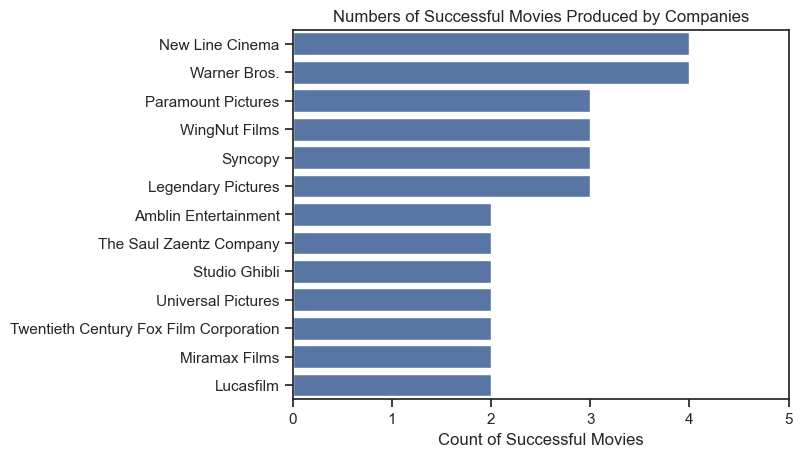

In [84]:
company_successful_movies = successful_movies['production_companies'].explode().value_counts().reset_index(name= 'successful_movies')
top_company = company_successful_movies[company_successful_movies['successful_movies'] > 1]
sns.barplot(
    data= top_company
    ,x= 'successful_movies'
    ,y= 'production_companies'
)
plt.xlim(0,5)
plt.title('Numbers of Successful Movies Produced by Companies')
plt.xlabel('Count of Successful Movies')
plt.ylabel('')